In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [2]:
# Image Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
# train(학습용) 데이터셋 로드
train_data = datasets.FashionMNIST(root='data', 
                                   train=True,        # 학습용 데이터셋 설정(True)
                                   download=True, 
                                   transform=transform                
                                  )

In [4]:
# test(학습용) 데이터셋 로드
test_data = datasets.FashionMNIST(root='data', 
                                  train=False,        # 검증용 데이터셋 설정(False)
                                  download=True, 
                                  transform=transform
                                 )

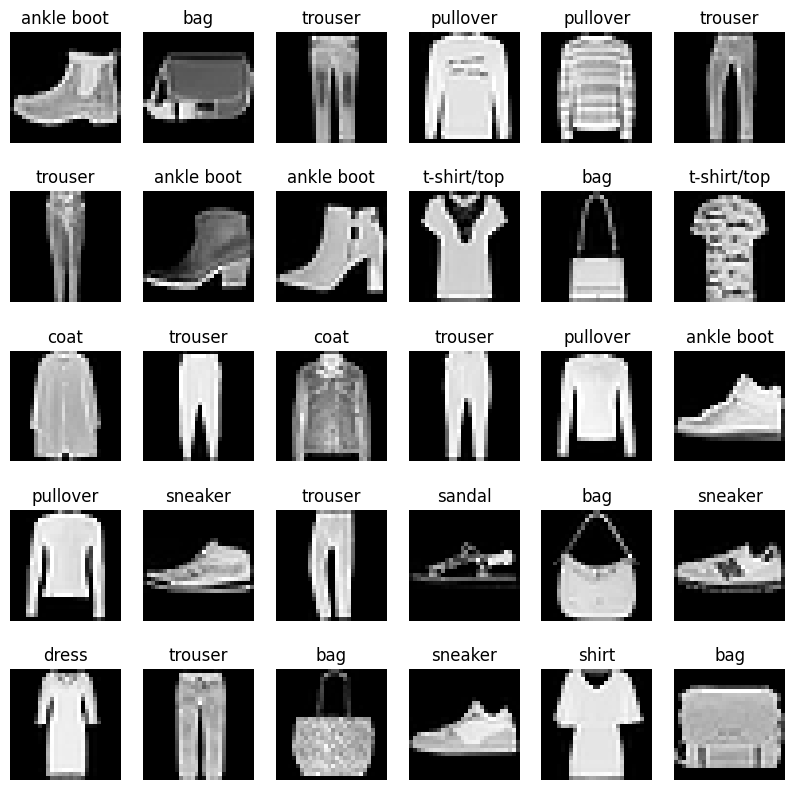

In [5]:
import matplotlib.pyplot as plt

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

In [6]:
batch_size = 32 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

In [8]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=False, 
                                          num_workers=num_workers)

In [9]:
# 1개의 배치 추출 후 Image, label의 shape 출력
img, lbl = next(iter(train_loader))
img.shape, lbl.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [10]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x     

In [12]:
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

DNNModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [14]:
from tqdm import tqdm  # Progress Bar 출력

In [16]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [17]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [18]:
# 최대 Epoch을 지정합니다.
num_epochs = 20

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력합니다.++
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 1875/1875 [00:37<00:00, 50.05it/s]


[INFO] val_loss has been improved from inf to 0.42905. Saving Model!
epoch 01, loss: 0.54824, acc: 0.80072, val_loss: 0.42905, val_accuracy: 0.84280


100%|██████████| 1875/1875 [00:38<00:00, 49.34it/s]


[INFO] val_loss has been improved from 0.42905 to 0.39595. Saving Model!
epoch 02, loss: 0.37604, acc: 0.86143, val_loss: 0.39595, val_accuracy: 0.86030


100%|██████████| 1875/1875 [00:23<00:00, 79.29it/s] 


[INFO] val_loss has been improved from 0.39595 to 0.38480. Saving Model!
epoch 03, loss: 0.33198, acc: 0.87770, val_loss: 0.38480, val_accuracy: 0.85560


100%|██████████| 1875/1875 [00:16<00:00, 114.06it/s]


[INFO] val_loss has been improved from 0.38480 to 0.34438. Saving Model!
epoch 04, loss: 0.30604, acc: 0.88590, val_loss: 0.34438, val_accuracy: 0.87630


100%|██████████| 1875/1875 [00:16<00:00, 114.66it/s]


[INFO] val_loss has been improved from 0.34438 to 0.34300. Saving Model!
epoch 05, loss: 0.28484, acc: 0.89458, val_loss: 0.34300, val_accuracy: 0.87690


100%|██████████| 1875/1875 [00:17<00:00, 110.20it/s]


[INFO] val_loss has been improved from 0.34300 to 0.31947. Saving Model!
epoch 06, loss: 0.27064, acc: 0.89990, val_loss: 0.31947, val_accuracy: 0.88520


100%|██████████| 1875/1875 [00:16<00:00, 110.61it/s]


epoch 07, loss: 0.25654, acc: 0.90392, val_loss: 0.33656, val_accuracy: 0.87850


100%|██████████| 1875/1875 [00:16<00:00, 111.75it/s]


epoch 08, loss: 0.24447, acc: 0.90847, val_loss: 0.34157, val_accuracy: 0.87870


100%|██████████| 1875/1875 [00:16<00:00, 110.52it/s]


[INFO] val_loss has been improved from 0.31947 to 0.30282. Saving Model!
epoch 09, loss: 0.23468, acc: 0.91190, val_loss: 0.30282, val_accuracy: 0.89380


100%|██████████| 1875/1875 [00:18<00:00, 102.81it/s]


epoch 10, loss: 0.22213, acc: 0.91610, val_loss: 0.32079, val_accuracy: 0.88870


100%|██████████| 1875/1875 [00:16<00:00, 112.91it/s]


epoch 11, loss: 0.21256, acc: 0.91977, val_loss: 0.34201, val_accuracy: 0.88580


100%|██████████| 1875/1875 [00:16<00:00, 111.13it/s]


epoch 12, loss: 0.20367, acc: 0.92303, val_loss: 0.34331, val_accuracy: 0.88560


100%|██████████| 1875/1875 [00:16<00:00, 111.63it/s]


epoch 13, loss: 0.19500, acc: 0.92767, val_loss: 0.34002, val_accuracy: 0.88830


100%|██████████| 1875/1875 [00:16<00:00, 110.51it/s]


epoch 14, loss: 0.18774, acc: 0.92938, val_loss: 0.34055, val_accuracy: 0.88880


100%|██████████| 1875/1875 [00:16<00:00, 112.92it/s]


epoch 15, loss: 0.18145, acc: 0.93140, val_loss: 0.33632, val_accuracy: 0.89370


100%|██████████| 1875/1875 [00:16<00:00, 112.33it/s]


epoch 16, loss: 0.17536, acc: 0.93397, val_loss: 0.33185, val_accuracy: 0.89220


100%|██████████| 1875/1875 [00:17<00:00, 110.29it/s]


epoch 17, loss: 0.16761, acc: 0.93675, val_loss: 0.34974, val_accuracy: 0.88650


100%|██████████| 1875/1875 [00:17<00:00, 108.97it/s]


epoch 18, loss: 0.16209, acc: 0.93923, val_loss: 0.36412, val_accuracy: 0.88870


100%|██████████| 1875/1875 [00:16<00:00, 110.55it/s]


epoch 19, loss: 0.15635, acc: 0.94077, val_loss: 0.36352, val_accuracy: 0.89350


100%|██████████| 1875/1875 [00:16<00:00, 111.48it/s]


epoch 20, loss: 0.14933, acc: 0.94392, val_loss: 0.36282, val_accuracy: 0.89420


In [19]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

<All keys matched successfully>

In [21]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.30282, evaluation accuracy: 0.89380
